# Train Low Test Models

This notebook is a streamlined notebook for generating minima of low test accuracy through three different means:
- Dataset Poisoning
- Adding Noise to Data
- Decreasing Dataset Sizes

## Imports

In [1]:
# Standard library
import copy
import os
import sys
import time

# Third-party
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Local package imports
from minima_volume.dataset_funcs import (
    prepare_datasets,
    save_dataset,
    save_model,
)
from minima_volume.train_funcs import evaluate, train_sam

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Input Parameters

In [2]:

# ==============================
# Base Input Parameters
# ==============================
# --- SEEDS ---
data_seed = 15            
model_seed = 5           

# --- Training configuration ---
epochs = 1000            

# --- Dataset configuration ---
base_data_size = 20      
dataset_type = "data"   
dataset_quantities = [0, 30, 100, 300, 700]

# --- Output configuration ---
base_output_dir = ""     
save_generated_dataset = True   
save_generated_models = True    


## Model + Dataset Specific Code

This is for specific code.

In [3]:
# User specifies the model module name
from minima_volume.models import swiss_model_data as model_module

test_dataset_size = 2000

# Generate dataset
x_base, y_base, x_test, y_test = model_module.get_dataset(
    base_data_size=base_data_size,
    dataset_quantities=dataset_quantities,
    test_dataset_size=test_dataset_size,
    noise=0.3, # default swiss params
    extra_pts=1000,
    dataset_type=dataset_type,
    seed=data_seed
)

# Swiss specific initialization parameters
input_dim = 2
output_dim = 1
hidden_dims = [32]*5

# Grab model
model_template = model_module.get_model(input_dim=input_dim, hidden_dims=hidden_dims, output_dim=output_dim, device=device, seed=model_seed)

# Grab loss and metrics
loss_fn = model_module.get_loss_fn()
other_metrics = model_module.get_additional_metrics()

## Training

We generate the various datasets used to train our models here, before training them. We record the losses, and what each model was trained on.

In [4]:
# ==============================
# Prepare datasets
# ==============================
x_base_train, y_base_train, x_additional, y_additional = prepare_datasets(
    x_base=x_base,
    y_base=y_base,
    dataset_type=dataset_type,
    dataset_quantities=dataset_quantities,
    base_data_size=base_data_size,
    data_seed=data_seed,
    seed_1=None,
    seed_2=None,
)

x_base_train = x_base_train.to(device)
y_base_train = y_base_train.to(device)
x_additional = x_additional.to(device)
y_additional = y_additional.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

# ==============================
# Training loop
# ==============================
all_models = []

for additional_data in dataset_quantities:
    # Assemble training dataset
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    # Initialize model (defined in the model-specific file)
    torch.manual_seed(model_seed)
    model = copy.deepcopy(model_template)
    optimizer = optim.AdamW(model.parameters(), lr=1e-3)
    batch_size = len(x_train)

    # Train model
    train_loss, train_other_metrics, test_loss, test_other_metrics = train_sam(
        model = model,
        x_train = x_train, y_train = y_train,
        x_test = x_test, y_test = y_test,
        loss_fn = loss_fn,
        metrics = other_metrics,
        optimizer = optimizer,
        epochs=epochs,
        batch_size=batch_size,
        verbose_every=100,
    )
    
    # Build dictionary dynamically for additional metrics
    train_metrics_dict = {}
    test_metrics_dict = {}
    if train_other_metrics is not None:
        # train_other_metrics is a list of dicts per epoch
        for metric_name in train_other_metrics[0].keys():  # keys from first epoch
            train_metrics_dict[f"train_{metric_name}"] = [m[metric_name] for m in train_other_metrics]
            test_metrics_dict[f"test_{metric_name}"] = [m[metric_name] for m in test_other_metrics]
    
    # Store results
    trained_model = {
        "model": model,
        "train_loss": train_loss,
        "test_loss": test_loss,
        "additional_data": additional_data,
        "dataset_type": dataset_type,
        **train_metrics_dict,  # dynamically include additional metrics
        **test_metrics_dict,
    }
    
    all_models.append(trained_model)

    print(f"Completed training with {additional_data} additional samples of {dataset_type}")

    # Free memory (important for large GPU datasets)
    del x_train, y_train
    torch.cuda.empty_cache()


[SAM] Epoch 1/1000: Train Loss 0.6922 | Test Loss 0.6927 | accs Train 0.4500 Test 0.5302


[SAM] Epoch 100/1000: Train Loss 0.3058 | Test Loss 1.0423 | accs Train 0.9000 Test 0.5795


[SAM] Epoch 200/1000: Train Loss 0.0957 | Test Loss 3.6838 | accs Train 0.9500 Test 0.5793


[SAM] Epoch 300/1000: Train Loss 0.0620 | Test Loss 6.4455 | accs Train 0.9500 Test 0.5833


[SAM] Epoch 400/1000: Train Loss 0.0294 | Test Loss 7.6828 | accs Train 1.0000 Test 0.5893


[SAM] Epoch 500/1000: Train Loss 0.0073 | Test Loss 8.6353 | accs Train 1.0000 Test 0.5855


[SAM] Epoch 600/1000: Train Loss 0.0080 | Test Loss 8.6698 | accs Train 1.0000 Test 0.5783


[SAM] Epoch 700/1000: Train Loss 0.0020 | Test Loss 9.7557 | accs Train 1.0000 Test 0.5765


[SAM] Epoch 800/1000: Train Loss 0.0023 | Test Loss 9.9795 | accs Train 1.0000 Test 0.5735


[SAM] Epoch 900/1000: Train Loss 0.0023 | Test Loss 10.1100 | accs Train 1.0000 Test 0.5725


[SAM] Epoch 1000/1000: Train Loss 0.0014 | Test Loss 11.2066 | accs Train 1.0000 Test 0.5730
Completed training with 0 additional samples of data
[SAM] Epoch 1/1000: Train Loss 0.6931 | Test Loss 0.6926 | accs Train 0.4800 Test 0.5245


[SAM] Epoch 100/1000: Train Loss 0.4864 | Test Loss 0.9109 | accs Train 0.7200 Test 0.5473


[SAM] Epoch 200/1000: Train Loss 0.2334 | Test Loss 1.5581 | accs Train 0.9200 Test 0.6660


[SAM] Epoch 300/1000: Train Loss 0.1243 | Test Loss 2.0594 | accs Train 1.0000 Test 0.7135


[SAM] Epoch 400/1000: Train Loss 0.0605 | Test Loss 2.4349 | accs Train 1.0000 Test 0.7250


[SAM] Epoch 500/1000: Train Loss 0.0307 | Test Loss 2.9020 | accs Train 1.0000 Test 0.7308


[SAM] Epoch 600/1000: Train Loss 0.0157 | Test Loss 3.0962 | accs Train 1.0000 Test 0.7528


[SAM] Epoch 700/1000: Train Loss 0.0083 | Test Loss 3.2621 | accs Train 1.0000 Test 0.7600


[SAM] Epoch 800/1000: Train Loss 0.0049 | Test Loss 3.3956 | accs Train 1.0000 Test 0.7662


[SAM] Epoch 900/1000: Train Loss 0.0049 | Test Loss 3.1294 | accs Train 1.0000 Test 0.7712


[SAM] Epoch 1000/1000: Train Loss 0.0053 | Test Loss 2.1136 | accs Train 1.0000 Test 0.7970
Completed training with 30 additional samples of data
[SAM] Epoch 1/1000: Train Loss 0.6942 | Test Loss 0.6924 | accs Train 0.4583 Test 0.5337


[SAM] Epoch 100/1000: Train Loss 0.5337 | Test Loss 0.6303 | accs Train 0.7083 Test 0.6305


[SAM] Epoch 200/1000: Train Loss 0.3803 | Test Loss 0.7440 | accs Train 0.8417 Test 0.6562


[SAM] Epoch 300/1000: Train Loss 0.2190 | Test Loss 0.8034 | accs Train 0.9333 Test 0.7452


[SAM] Epoch 400/1000: Train Loss 0.1264 | Test Loss 0.7733 | accs Train 0.9667 Test 0.8240


[SAM] Epoch 500/1000: Train Loss 0.0684 | Test Loss 0.7259 | accs Train 1.0000 Test 0.8675


[SAM] Epoch 600/1000: Train Loss 0.0378 | Test Loss 0.6853 | accs Train 1.0000 Test 0.8992


[SAM] Epoch 700/1000: Train Loss 0.0194 | Test Loss 0.6874 | accs Train 1.0000 Test 0.9095


[SAM] Epoch 800/1000: Train Loss 0.0104 | Test Loss 0.7210 | accs Train 1.0000 Test 0.9167


[SAM] Epoch 900/1000: Train Loss 0.0082 | Test Loss 0.6584 | accs Train 1.0000 Test 0.9245


[SAM] Epoch 1000/1000: Train Loss 0.0047 | Test Loss 0.6705 | accs Train 1.0000 Test 0.9317
Completed training with 100 additional samples of data
[SAM] Epoch 1/1000: Train Loss 0.6939 | Test Loss 0.6923 | accs Train 0.4813 Test 0.5393


[SAM] Epoch 100/1000: Train Loss 0.5689 | Test Loss 0.6151 | accs Train 0.6719 Test 0.6442


[SAM] Epoch 200/1000: Train Loss 0.3510 | Test Loss 0.4118 | accs Train 0.8344 Test 0.7953


[SAM] Epoch 300/1000: Train Loss 0.1255 | Test Loss 0.1796 | accs Train 0.9969 Test 0.9605


[SAM] Epoch 400/1000: Train Loss 0.0328 | Test Loss 0.0707 | accs Train 1.0000 Test 0.9870


[SAM] Epoch 500/1000: Train Loss 0.0103 | Test Loss 0.0502 | accs Train 1.0000 Test 0.9905


[SAM] Epoch 600/1000: Train Loss 0.0046 | Test Loss 0.0420 | accs Train 1.0000 Test 0.9908


[SAM] Epoch 700/1000: Train Loss 0.0030 | Test Loss 0.0334 | accs Train 1.0000 Test 0.9922


[SAM] Epoch 800/1000: Train Loss 0.0017 | Test Loss 0.0414 | accs Train 1.0000 Test 0.9908


[SAM] Epoch 900/1000: Train Loss 0.0045 | Test Loss 0.0289 | accs Train 1.0000 Test 0.9938


[SAM] Epoch 1000/1000: Train Loss 0.0038 | Test Loss 0.0551 | accs Train 1.0000 Test 0.9902
Completed training with 300 additional samples of data
[SAM] Epoch 1/1000: Train Loss 0.6936 | Test Loss 0.6923 | accs Train 0.4792 Test 0.5347


[SAM] Epoch 100/1000: Train Loss 0.5893 | Test Loss 0.6061 | accs Train 0.6722 Test 0.6542


[SAM] Epoch 200/1000: Train Loss 0.3435 | Test Loss 0.3625 | accs Train 0.8431 Test 0.8177


[SAM] Epoch 300/1000: Train Loss 0.0554 | Test Loss 0.0769 | accs Train 1.0000 Test 0.9930


[SAM] Epoch 400/1000: Train Loss 0.0169 | Test Loss 0.0426 | accs Train 1.0000 Test 0.9935


[SAM] Epoch 500/1000: Train Loss 0.0064 | Test Loss 0.0295 | accs Train 1.0000 Test 0.9948


[SAM] Epoch 600/1000: Train Loss 0.0026 | Test Loss 0.0279 | accs Train 1.0000 Test 0.9942


[SAM] Epoch 700/1000: Train Loss 0.0038 | Test Loss 0.0237 | accs Train 1.0000 Test 0.9955


[SAM] Epoch 800/1000: Train Loss 0.0023 | Test Loss 0.0239 | accs Train 1.0000 Test 0.9952


[SAM] Epoch 900/1000: Train Loss 0.0015 | Test Loss 0.0239 | accs Train 1.0000 Test 0.9952


[SAM] Epoch 1000/1000: Train Loss 0.0010 | Test Loss 0.0239 | accs Train 1.0000 Test 0.9952
Completed training with 700 additional samples of data


## Training Summary

In [5]:
# ====================================
# Summary of Training Results
# ====================================
print("=== True Generalization ===")
for model_data in all_models:
    model = model_data["model"]
    additional_data = model_data["additional_data"]

    test_loss, test_metrics = evaluate(
        model=model,
        x_test=x_test,
        y_test=y_test,
        loss_fn=loss_fn,
        metrics=other_metrics
    )

    metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in test_metrics.items()])
    print(
        f"{additional_data:>4} samples | "
        f"Test Loss: {test_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
    )

print("\n=== Model Diagnostics by Training Data ===")
for additional_data in dataset_quantities:
    # Build dataset with this many additional samples
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    print(f"\nDataset type: {dataset_type}, additional samples: {additional_data}")

    for model_data in all_models:
        model = model_data["model"]
        model_additional_data = model_data["additional_data"]

        train_loss, train_metrics = evaluate(
            model=model,
            x_test=x_train,
            y_test=y_train,
            loss_fn=loss_fn,
            metrics=other_metrics
        )

        metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in train_metrics.items()])
        print(
            f" Model {model_additional_data:>4} | "
            f"Train Loss: {train_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
        )

    # Free memory if large
    del x_train, y_train
    torch.cuda.empty_cache()

=== True Generalization ===
   0 samples | Test Loss: 11.2066 | accs: 0.5730
  30 samples | Test Loss: 2.1136 | accs: 0.7970
 100 samples | Test Loss: 0.6705 | accs: 0.9317
 300 samples | Test Loss: 0.0551 | accs: 0.9902
 700 samples | Test Loss: 0.0239 | accs: 0.9952

=== Model Diagnostics by Training Data ===

Dataset type: data, additional samples: 0
 Model    0 | Train Loss: 0.0014 | accs: 1.0000
 Model   30 | Train Loss: 0.0068 | accs: 1.0000
 Model  100 | Train Loss: 0.0052 | accs: 1.0000
 Model  300 | Train Loss: 0.0047 | accs: 1.0000
 Model  700 | Train Loss: 0.0009 | accs: 1.0000

Dataset type: data, additional samples: 30
 Model    0 | Train Loss: 13.7340 | accs: 0.5800
 Model   30 | Train Loss: 0.0053 | accs: 1.0000
 Model  100 | Train Loss: 0.0061 | accs: 1.0000
 Model  300 | Train Loss: 0.0050 | accs: 1.0000
 Model  700 | Train Loss: 0.0014 | accs: 1.0000

Dataset type: data, additional samples: 100
 Model    0 | Train Loss: 10.2312 | accs: 0.6167
 Model   30 | Train Loss:

### Model + Data Specific Verification

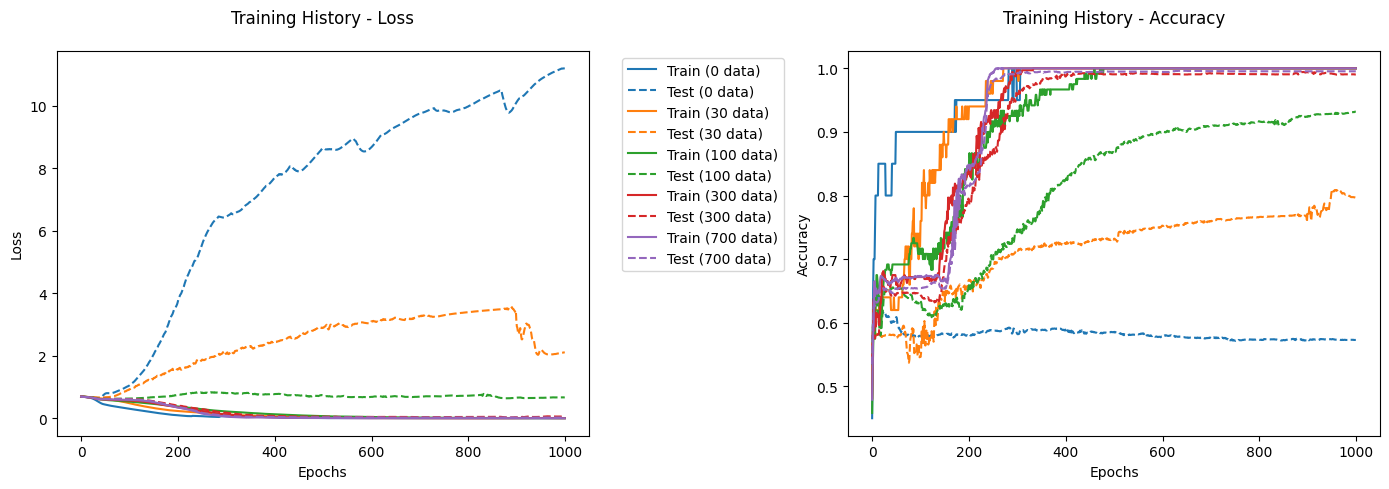

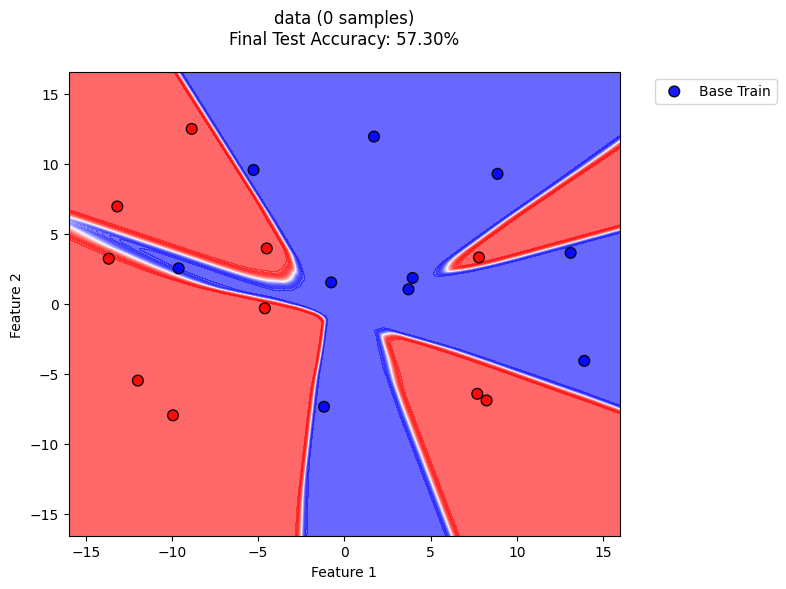

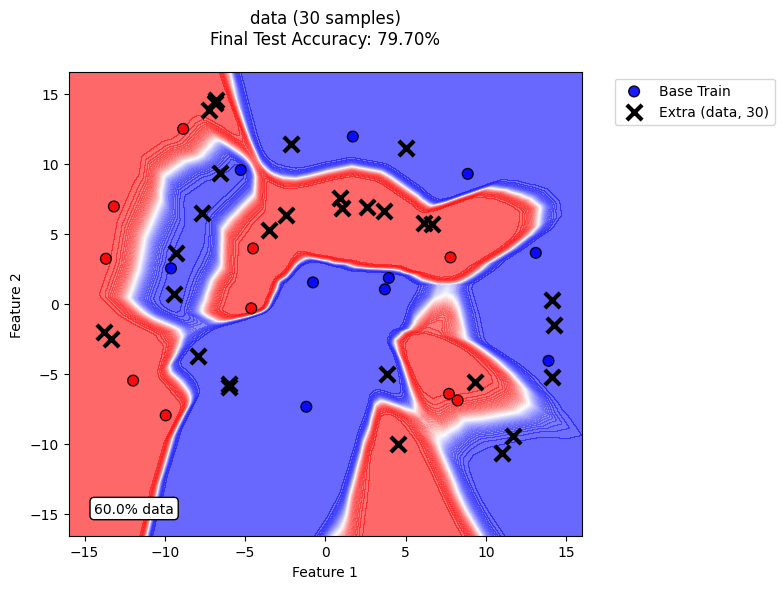

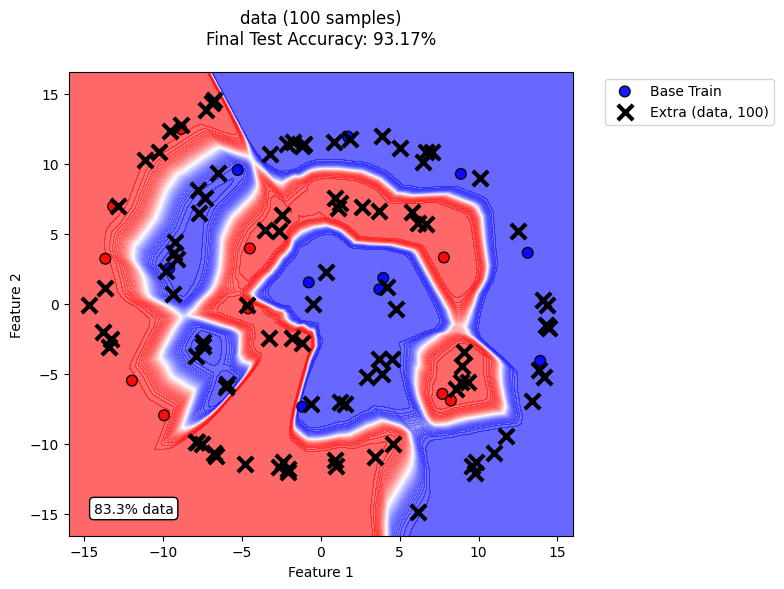

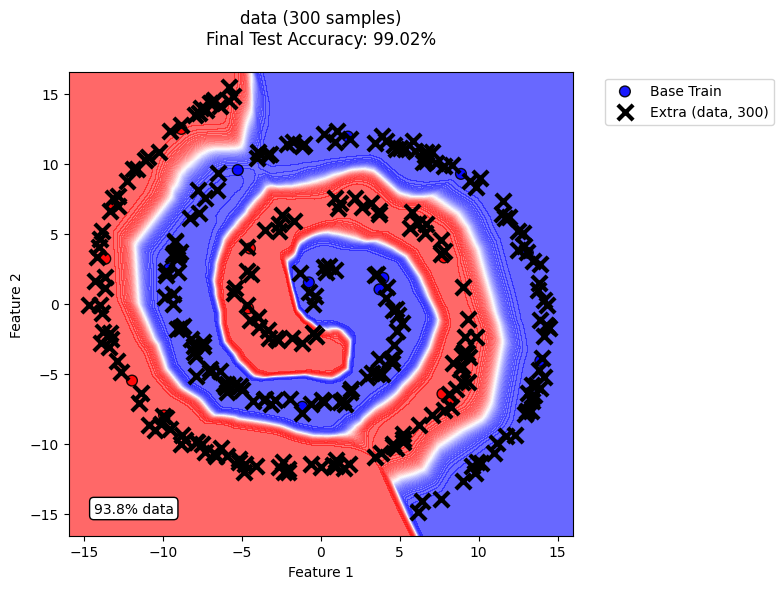

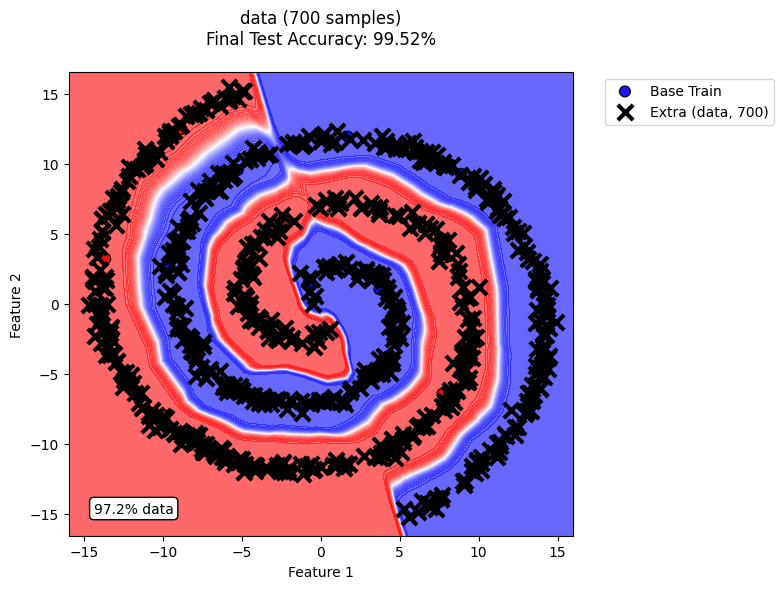

In [6]:
model_module.verify_model_results(
    all_models=all_models,
    x_base_train=x_base_train,
    y_base_train=y_base_train,
    x_additional=x_additional,
    y_additional=y_additional,
    x_test=x_test,
    y_test=y_test,
    dataset_quantities=dataset_quantities,
    dataset_type=dataset_type,
)

## Model Saving

In [7]:
# ====================================
# Save Datasets and Models
# ====================================
output_folder = "models_and_data"
# Save dataset (Possible to skip)
if save_generated_dataset:
    save_dataset(
        folder=output_folder,
        filename="dataset.pt",
        x_base_train=x_base_train,
        y_base_train=y_base_train,
        x_additional=x_additional,
        y_additional=y_additional,
        x_test=x_test,
        y_test=y_test,
        dataset_quantities=dataset_quantities,
        dataset_type=dataset_type,
    )
    print(f"Saved dataset to {output_folder}/dataset.pt")

# Save trained models
if save_generated_models:
    for model_data in all_models:
        filename = f"model_additional_{model_data['additional_data']}.pt"
        save_model(
            folder=output_folder,
            filename=filename,
            model=model_data["model"],
            train_loss=model_data["train_loss"],
            train_accs=model_data["train_accs"],
            test_loss=model_data["test_loss"],
            test_accs=model_data["test_accs"],
            additional_data=model_data["additional_data"],
            dataset_type=model_data["dataset_type"],
        )
        print(f"Saved model: {output_folder}/{filename}")

✅ Dataset saved to models_and_data\dataset.pt
Saved dataset to models_and_data/dataset.pt
✅ Model saved to models_and_data\model_additional_0.pt
Saved model: models_and_data/model_additional_0.pt
✅ Model saved to models_and_data\model_additional_30.pt
Saved model: models_and_data/model_additional_30.pt
✅ Model saved to models_and_data\model_additional_100.pt
Saved model: models_and_data/model_additional_100.pt
✅ Model saved to models_and_data\model_additional_300.pt
Saved model: models_and_data/model_additional_300.pt
✅ Model saved to models_and_data\model_additional_700.pt
Saved model: models_and_data/model_additional_700.pt
